1 - для частот взяты 250 точек в статье, возьмем 256 = 1 секунда = 2/3 сонного веретена

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import math

from tqdm.notebook import tqdm
import torch
from torchaudio.transforms import Spectrogram
from scipy.signal import butter, filtfilt


In [2]:
PATH = "/home/gromov_n/MASS/ss2/"

In [3]:
def ReadSignals():
    all_data = {}
    for file in os.listdir(PATH):
        if "PSG" in file:
            data = mne.io.read_raw_edf(PATH + file, verbose=False)
            raw_data = data.get_data()

            labels = np.load("data/" + file + "labels.npy")
            assert len(labels) == len(raw_data[0])
            number = int(file[8:10])
            all_data[number] = [raw_data, labels]
           
            data.close()
    return all_data

In [4]:
all_data = ReadSignals()
assert len(all_data) == 19

In [5]:
test_record = all_data[1][0]

In [5]:
transform = Spectrogram(n_fft=256)
spectrogram = transform(torch.FloatTensor(test_record))

In [6]:
new_labels = []
for i in range(0, all_data[1][0].shape[1] - 128, 128):
    label = all_data[1][1][i:i+256].sum() > 100
    new_labels.append(label)

In [19]:
new_labels

57911

In [11]:
spectrogram = spectrogram[:19]

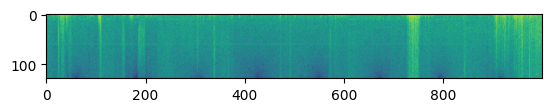

In [10]:
plt.imshow(np.log(spectrogram[0][:, :1000]))

In [12]:
ss_spectrogram = []
normal_spectorgram = []
for i in range(len(new_labels)):
    if new_labels[i] == 1:
        ss_spectrogram.append(spectrogram[:, :, i])
    else:
        normal_spectorgram.append(spectrogram[:, :, i])
        

In [19]:
average_ss_spectrogram = np.mean(ss_spectrogram, axis=0)
average_normal_spectorgram = np.mean(normal_spectorgram, axis=0)

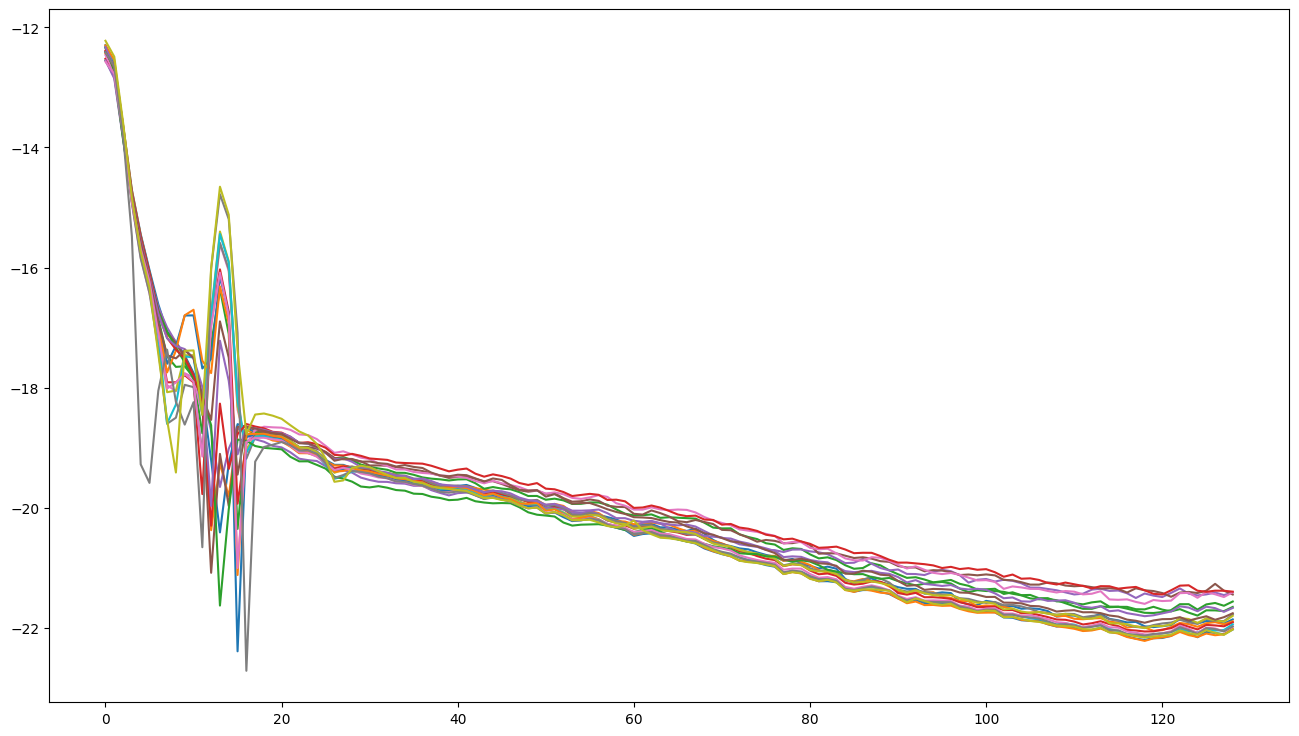

In [27]:
plt.figure(figsize=(16, 9))
for i in range(19):
    plt.plot(np.log(np.abs(average_normal_spectorgram[i] - average_ss_spectrogram[i])))

Что и было очевидно - фильтр до 20 Гц

In [7]:
def broad_filter(signal, fs, lowcut=0.1, highcut=20):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [8]:
test_record = test_record[:19]

In [9]:
filtered_signal = broad_filter(test_record, 256)

In [10]:
def CrossCorelationMaxima(signal_a, signal_b, M=20):
    normalize_a = (signal_a ** 2).sum() 
    normalize_b = (signal_b ** 2).sum() 
    
    R = [(signal_a * signal_b).sum() / np.sqrt(normalize_a * normalize_b)]
    for m in range(1, M):
        R.append((signal_a[:-m] * signal_b[m:]).sum() / np.sqrt(normalize_a * normalize_b))
    return np.max(R)

In [12]:
RECEPTIVE_FIELD = 256
OVERLAP = 0 # now is 0 should test 520

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD, ov = OVERLAP):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(ov, L- rf - ov, rf)):
        train_seq = x[:, i-ov:i+rf+ov]
        train_label = labels[i:i+rf].sum() > 100
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [13]:
samples = CreateSamples(filtered_signal, all_data[1][1])

  0%|          | 0/28955 [00:00<?, ?it/s]

In [14]:
def CreateGraph(sample):
    n = len(sample)
    graph = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            m = CrossCorelationMaxima(sample[i], sample[j])
            graph[i, j] = m
    return graph

In [15]:
def cnk(m, l):
 #m-сколько осталоась выбрать,l - номер элемента с которого начниаем
 #int i,j;
    if m == 0:
        ALL_COMBS.append(p.copy().astype(int))
        return
    for i in range(l, n-m): 
        p[k-m]=NODES[i];
        cnk(m-1,i+1);


In [16]:
ALL_COMBS = []
n = 20
NODES = list(range(19))

for k in range(1, n+1):
    comb = math.comb(n, k)
    p = np.zeros(k)
    cnk(k, 0)    
        

In [17]:
def CheckComplete(Graph, indexes):
    subgraph = Graph[indexes]
    subgraph = subgraph[:, indexes]

    return subgraph.sum() == len(indexes) ** 2

In [18]:
def CreateHyperGraph(graph, all_combs):
    complete_subgraphs = []
    for comb in all_combs:
        if len(comb) > 1:
            if CheckComplete(graph, list(comb)):
                complete_subgraphs.append(comb)
    subset_indexes = []
    complete_subgraphs_set = [set(complete_subgraphs[i]) for i in range(len(complete_subgraphs))]
    
    for i in range(len(complete_subgraphs)-1):
        for j in range(i+1, len(complete_subgraphs)):
            if complete_subgraphs_set[i] <= complete_subgraphs_set[j]:
                subset_indexes.append(i)
                break
    complete_subgraphs_correct = [complete_subgraphs[i] for i in range(len(complete_subgraphs)) 
                                  if i not in subset_indexes]
    return complete_subgraphs_correct

In [19]:
def GetNeighbors(node, edges):
    neighbors = []
    for edge in edges:
        if node in edge:
            for neighb in edge:
                if neighb != node and neighb not in neighbors:
                    neighbors.append(neighb)
    return neighbors

def IndicatorHCC1(edges, node, u, t):
    for edge in edges:
        if u in edge and t in edge and node not in edge:
            return 1
    return 0

def HCC1(edges, nodes):
    hcc1 = np.zeros(len(nodes))
    for node in nodes:
        neighbors = GetNeighbors(node, edges)
        sum_ind = 0
        for i in range(len(neighbors) - 1):
            for j in range(i+1, len(neighbors)):
                indicator = IndicatorHCC1(edges, node, neighbors[i], neighbors[j])
                sum_ind += indicator
        if len(neighbors) > 1:
            hcc1[node] = 2 * sum_ind / (len(neighbors) * (len(neighbors) - 1)) 
    return hcc1


def IndicatorHCC2(edges, node, u, t):
    for edge in edges:
        if u in edge and t in edge and node in edge:
            return 1
    return 0

def HCC2(edges, nodes):
    hcc2 = np.zeros(len(nodes))
    for node in nodes:
        neighbors = GetNeighbors(node, edges)
        sum_ind = 0
        for i in range(len(neighbors) - 1):
            for j in range(i+1, len(neighbors)):
                indicator = IndicatorHCC2(edges, node, neighbors[i], neighbors[j])
                sum_ind += indicator
        if len(neighbors) > 1:
            hcc2[node] = 2 * sum_ind / (len(neighbors) * (len(neighbors) - 1)) 
    return hcc2

def GetIncludedEdges(node, edges):
    included_edges = []
    for edge in edges:
        if node in edge:
            included_edges.append(len(edge))
    return included_edges

def HCC3(edges, nodes):
    hcc3 = np.zeros(len(nodes))
    for node in nodes:
        neighbors = GetNeighbors(node, edges)
        included_edges = np.array(GetIncludedEdges(node, edges))
        sum_edges = (included_edges - 1).sum()
        if len(neighbors) != 0 and len(included_edges) > 1:
            hcc3[node] = (sum_edges - len(neighbors)) / (len(neighbors) * (len(included_edges) - 1))
    return hcc3
                

In [20]:
def CreateHyperSamples(samples):
    all_data = []
    all_labels = []
    
    for data, label in tqdm(samples):
        all_labels.append(label)
        graph = CreateGraph(data)
        graph = graph > 0.8    
        hgraph = CreateHyperGraph(graph, ALL_COMBS)
        all_data.append(np.concatenate((HCC1(hgraph, NODES), HCC2(hgraph, NODES), HCC3(hgraph, NODES))))
    return all_data, all_labels

In [115]:
x, y = CreateHyperSamples(samples)

  0%|          | 0/28955 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
silence_samples = [sample for sample in samples if sample[1] == 0]
ss_samples = [sample for sample in samples if sample[1] == 1]

In [86]:
ss_graphs = []
ss_hgraphs = []
silence_graphs = []
silence_hgraphs = []

num_samples = 9
silence_idxs = np.random.randint(0, len(silence_samples)-1, num_samples)
ss_idxs = np.random.randint(0, len(ss_samples)-1, num_samples)
print(silence_idxs)
print(ss_idxs)

for i in tqdm(range(num_samples)):
    sample = samples[silence_idxs[i]][0]
    graph = CreateGraph(sample)
    graph = graph > 0.5 
    silence_graphs.append(graph)
    silence_hgraphs.append(CreateHyperGraph(graph, ALL_COMBS))
    
    sample = samples[ss_idxs[i]][0]
    graph = CreateGraph(sample)
    graph = graph > 0.5 
    ss_graphs.append(graph)
    ss_hgraphs.append(CreateHyperGraph(graph, ALL_COMBS))

[14790 24589 17202 24985 15126 15873 15433 24011 15009]
[1075  874 1905  560 1125 1423 2433 2175 2235]


  0%|          | 0/9 [00:00<?, ?it/s]

In [87]:
num_rows = int(np.sqrt(num_samples))

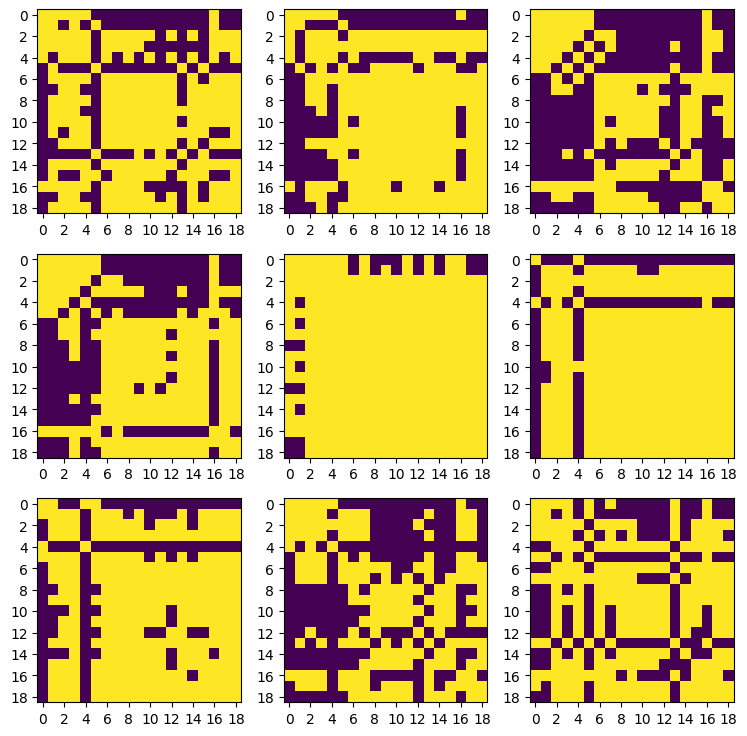

In [88]:
fig, axs = plt.subplots(num_rows, num_rows, figsize=(9, 9))
for ind in range(num_samples):
    row = ind // num_rows
    col = ind % num_rows
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))

    axs[row, col].imshow(silence_graphs[ind])

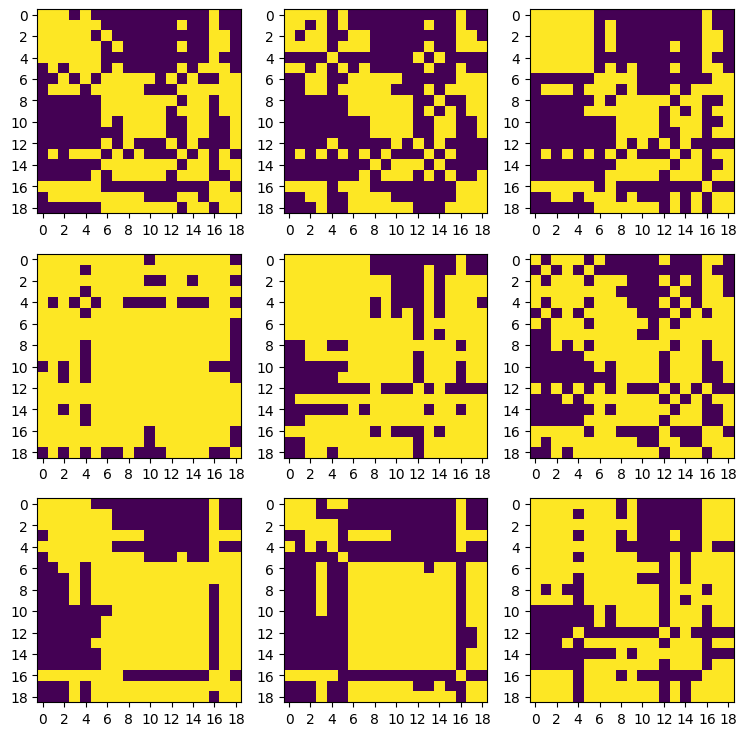

In [89]:
fig, axs = plt.subplots(num_rows, num_rows, figsize=(9, 9))
for ind in range(num_samples):
    row = ind // num_rows
    col = ind % num_rows
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))

    axs[row, col].imshow(ss_graphs[ind])

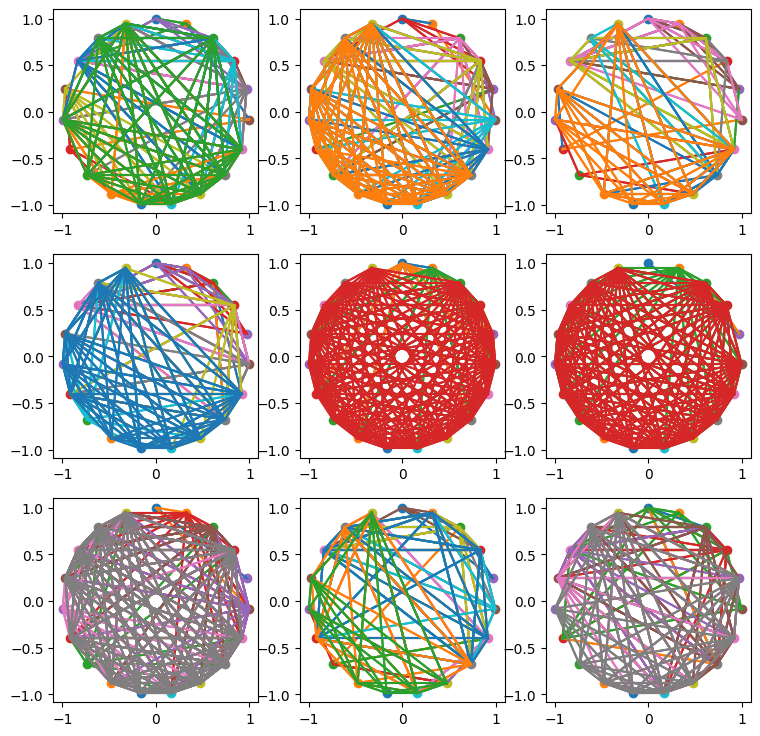

In [90]:
fig, axs = plt.subplots(num_rows, num_rows, figsize=(9, 9))

for ind in range(num_samples):
    row = ind // num_rows
    col = ind % num_rows
    for i in range(19):
        x = np.sin(i * 2*np.pi / 19)
        y = np.cos(i * 2*np.pi / 19)
        axs[row][col].scatter(x, y)

    for i, edge in enumerate(silence_hgraphs[ind]):
        for node1 in edge:
            for node2 in edge:
                x = np.sin(np.array([node1, node2]) * 2 * np.pi / 19)
                y = np.cos(np.array([node1, node2]) * 2 * np.pi / 19)
                axs[row][col].plot(x, y, color="C" + str(i))

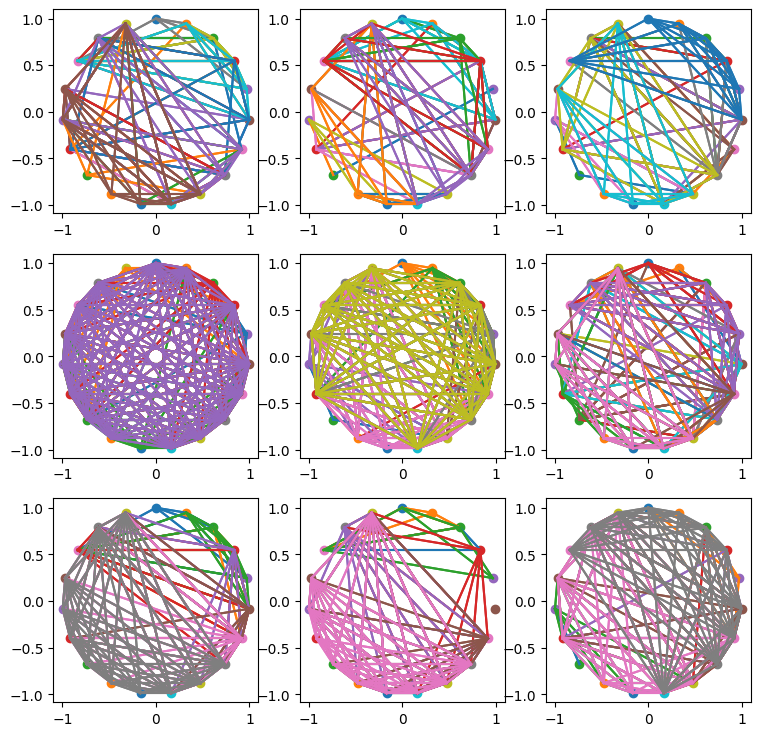

In [91]:
fig, axs = plt.subplots(num_rows, num_rows, figsize=(9, 9))

for ind in range(num_samples):
    row = ind // num_rows
    col = ind % num_rows
    for i in range(19):
        x = np.sin(i * 2*np.pi / 19)
        y = np.cos(i * 2*np.pi / 19)
        axs[row][col].scatter(x, y)

    for i, edge in enumerate(ss_hgraphs[ind]):
        for node1 in edge:
            for node2 in edge:
                x = np.sin(np.array([node1, node2]) * 2 * np.pi / 19)
                y = np.cos(np.array([node1, node2]) * 2 * np.pi / 19)
                axs[row][col].plot(x, y, color="C" + str(i))

In [92]:
ss_chars = []
silence_chars = []
for i in range(num_samples):
    ss_chars.append(np.concatenate((HCC1(ss_hgraphs[i], NODES), HCC2(ss_hgraphs[i], NODES), HCC3(ss_hgraphs[i], NODES))))
    silence_chars.append(np.concatenate((HCC1(silence_hgraphs[i], NODES), HCC2(silence_hgraphs[i], NODES), 
                                         HCC3(silence_hgraphs[i], NODES))))    

In [93]:
from sklearn.decomposition import PCA

In [94]:
pca = PCA(n_components=3)
comps = pca.fit_transform(np.concatenate((np.array(ss_chars), np.array(silence_chars))))

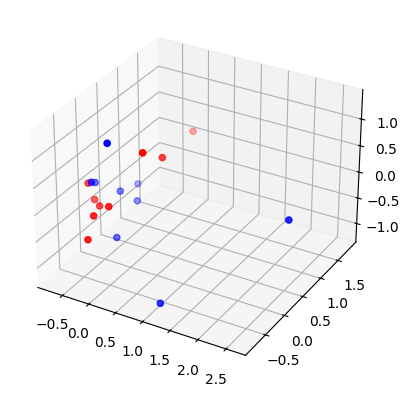

In [95]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(comps[:num_samples, 0], comps[:num_samples, 1], comps[:num_samples, 2],color="Red")
ax.scatter(comps[num_samples:, 0], comps[num_samples:, 1], comps[num_samples:, 2], color="Blue")

In [96]:
pca = PCA(n_components=2)
comps = pca.fit_transform(np.concatenate((np.array(ss_chars), np.array(silence_chars))))

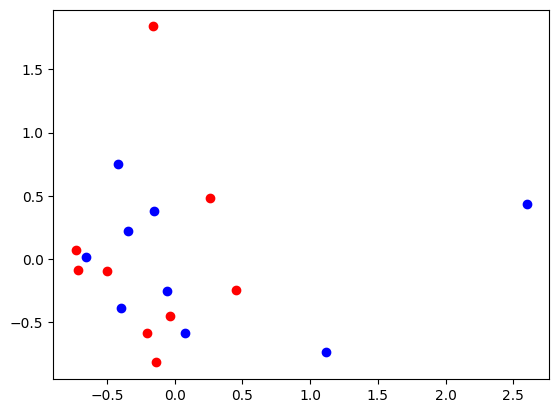

In [97]:
plt.scatter(comps[:num_samples, 0], comps[:num_samples, 1], color="Red")
plt.scatter(comps[num_samples:, 0], comps[num_samples:, 1], color="Blue")

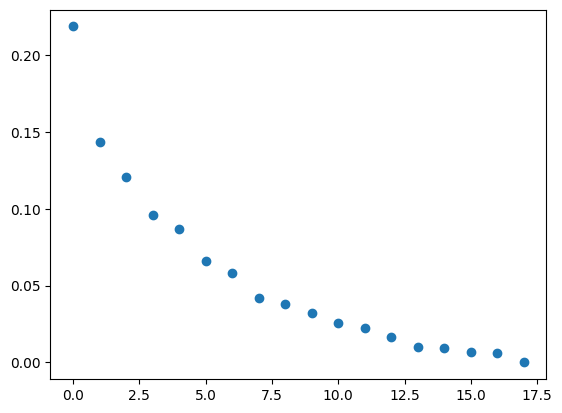

In [98]:
pca = PCA(n_components=18) #should be 19 * 3
comps = pca.fit_transform(np.concatenate((np.array(ss_chars), np.array(silence_chars))))
plt.scatter(np.arange(18), pca.explained_variance_/pca.explained_variance_.sum())

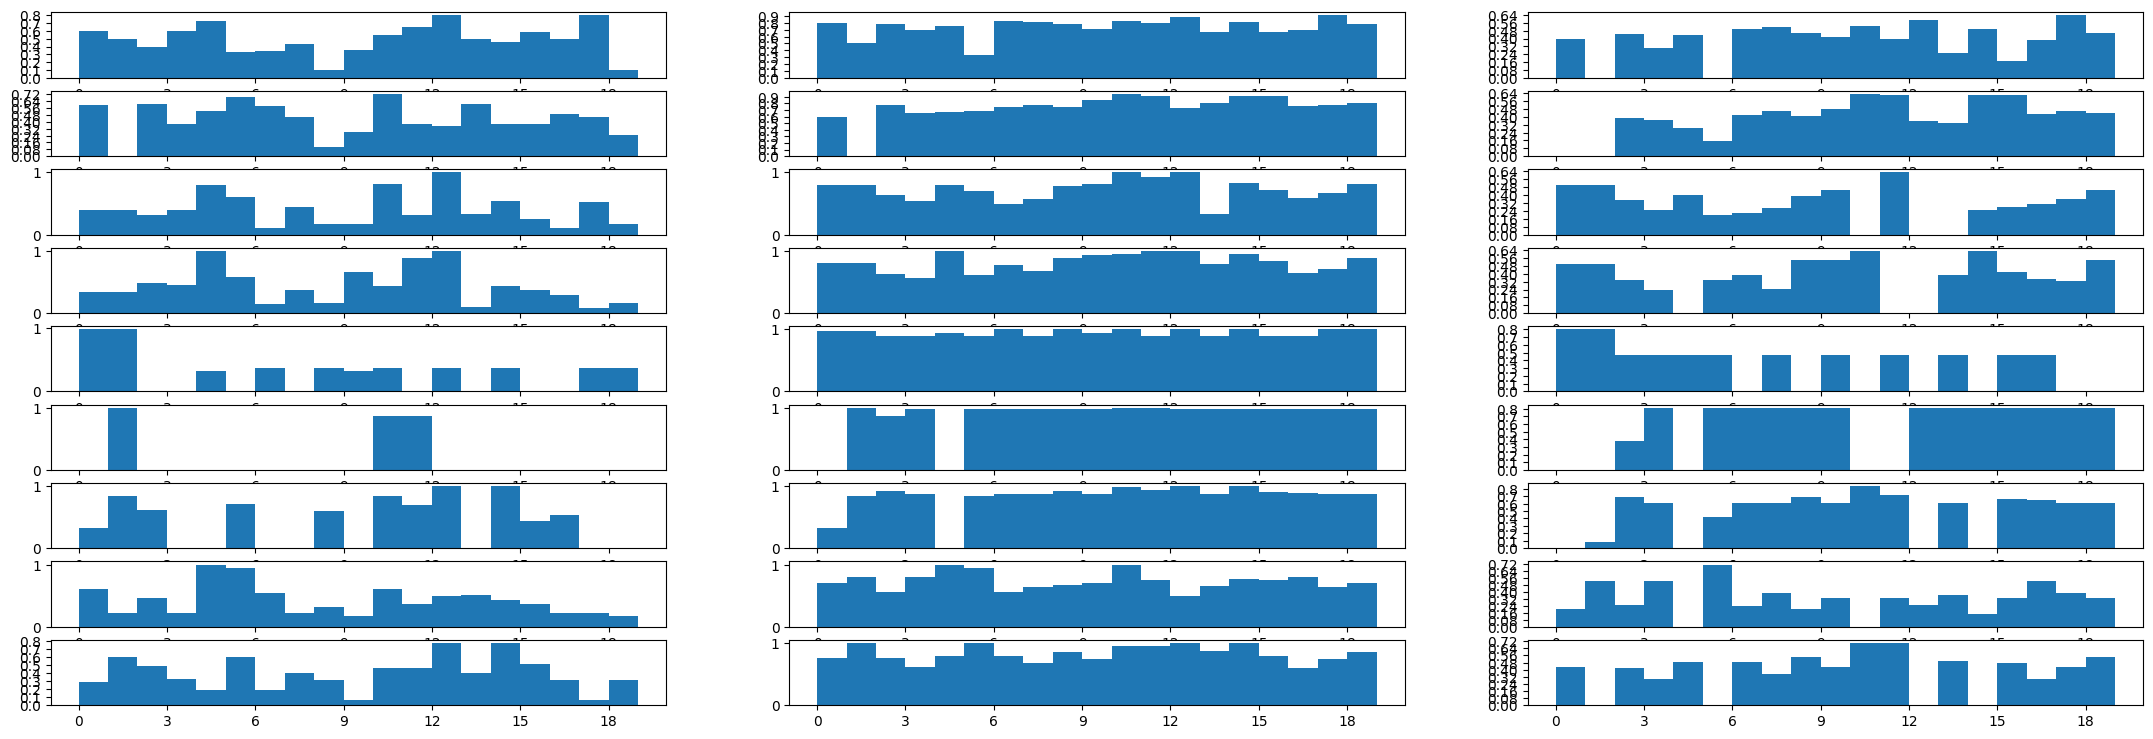

In [99]:
fig, axs = plt.subplots(num_samples, 3, figsize=(27, 9))
for row in range(num_samples):
    for col in range(3):
        axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[row, col].stairs(silence_chars[row][19*col:19*(col+1)], list(range(20)), fill=True)    

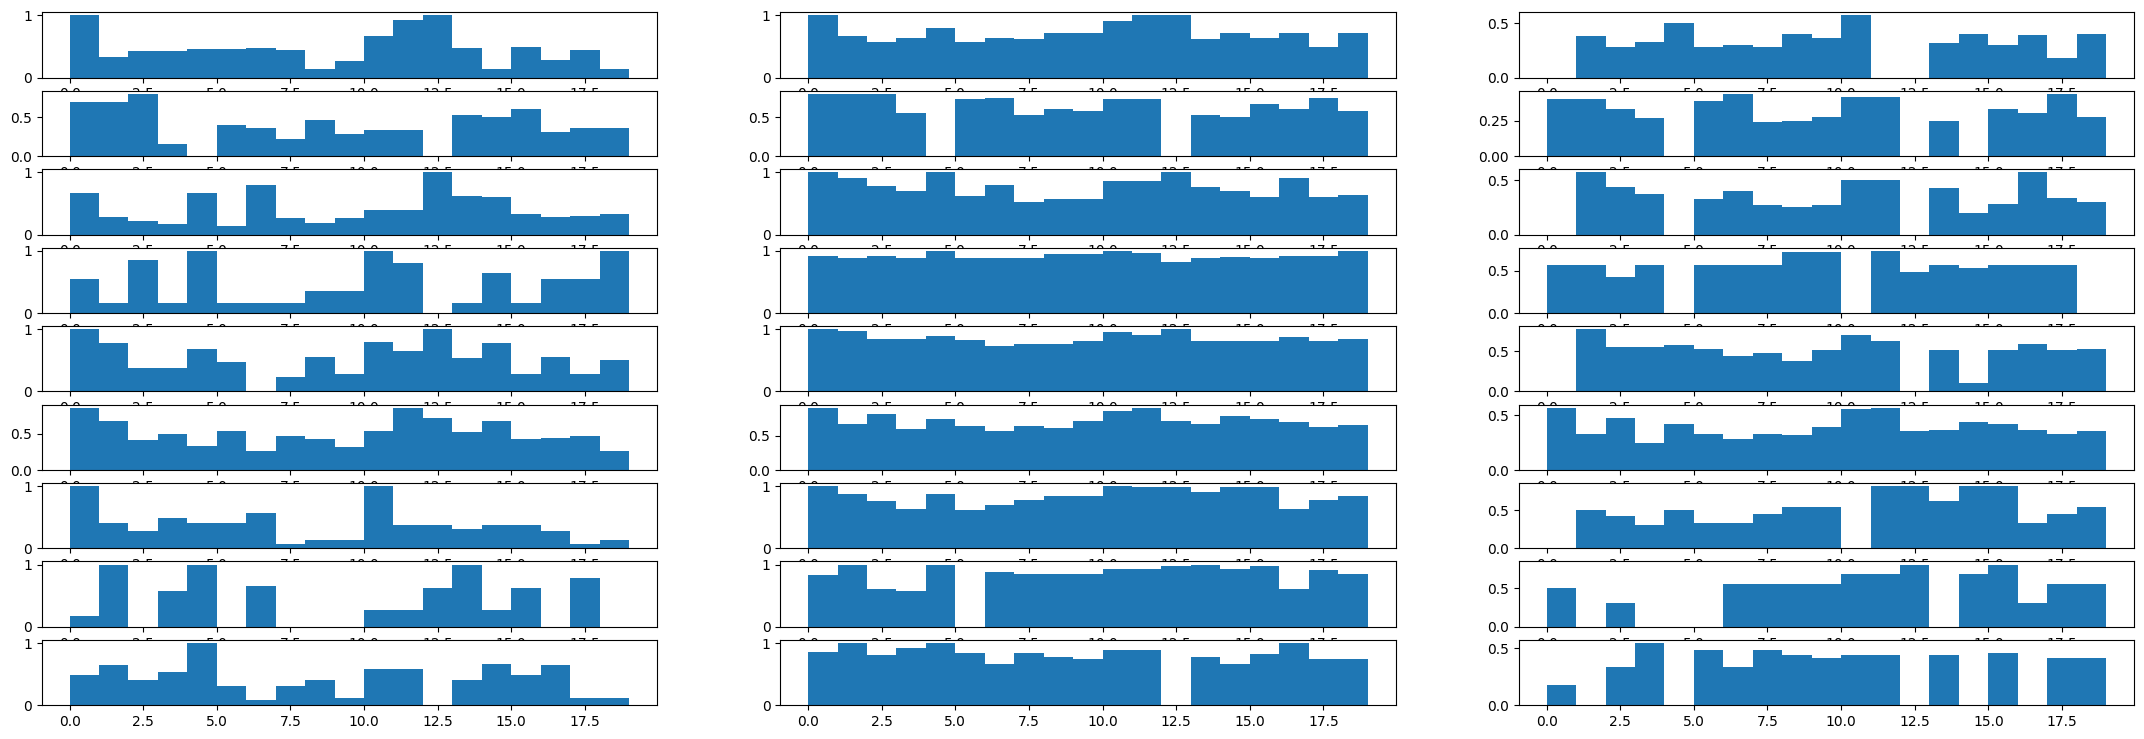

In [100]:
fig, axs = plt.subplots(num_samples, 3, figsize=(27, 9))
for row in range(num_samples):
    for col in range(3):
        axs[row, col].stairs(ss_chars[row][19*col:19*(col+1)], list(range(20)), fill=True)    

# Drafts

In [22]:
hgraph

[array([ 6,  8, 12]),
 array([ 8, 12, 14]),
 array([ 6,  7,  9, 17]),
 array([ 6,  8,  9, 17]),
 array([ 7,  9, 13, 15]),
 array([ 2,  3,  7, 16, 17]),
 array([ 2,  6,  7, 16, 17]),
 array([ 0,  1,  2,  3,  5, 16]),
 array([ 0,  2,  3,  4,  5, 16]),
 array([ 8,  9, 10, 11, 13, 14, 15])]

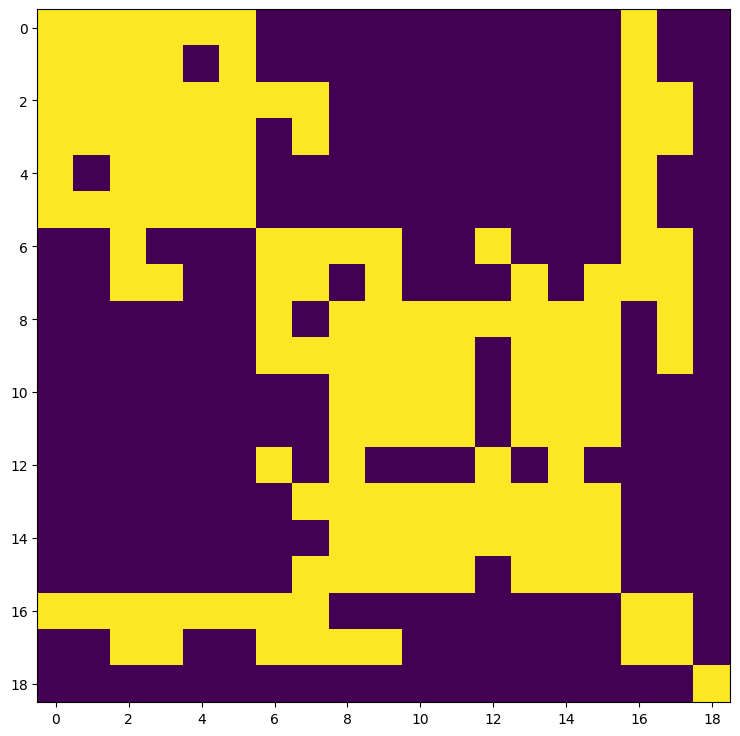

In [115]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.imshow(graph)


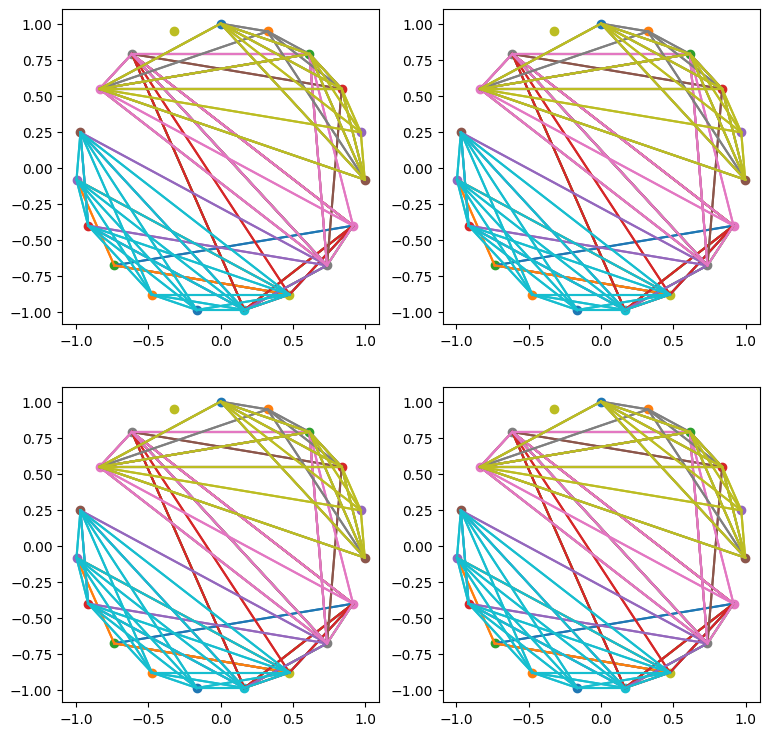

In [31]:
connect = np.array([1, 2, 12])

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

for ind in range(4):
    row = ind // 2
    col = ind % 2
    for i in range(19):
        x = np.sin(i * 2*np.pi / 19)
        y = np.cos(i * 2*np.pi / 19)
        axs[row][col].scatter(x, y)

    for i, edge in enumerate(hgraph):
        for node1 in edge:
            for node2 in edge:
                x = np.sin(np.array([node1, node2]) * 2 * np.pi / 19)
                y = np.cos(np.array([node1, node2]) * 2 * np.pi / 19)
                axs[row][col].plot(x, y, color="C" + str(i))
    
# x = np.sin(connect * 2*np.pi / 19)
# idxs = np.argsort(x)   
# x1 = x[:2]
#x2 = 
#k, b = CalculateKB(x[idxs][:2], y2[:2])
#y1 = np.array((np.cos(connect * 2*np.pi / 19)[idxs][0], k *x[1] + b, np.cos(connect * 2*np.pi / 19)[idxs][-1]))
#y2 = np.concatenate((np.cos(connect * 2*np.pi / 19)[idxs][:2], np.array(y1[-1])[..., None]))
#plt.fill_between(x[idxs], y1, y2)

In [60]:
hcc3 = HCC3(complete_subgraphs_correct, a)

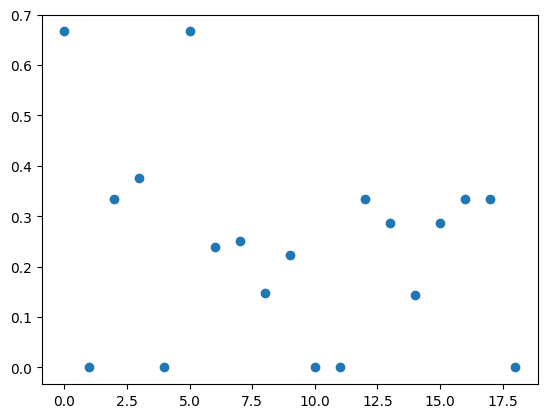

In [61]:
plt.scatter(list(range(19)), hcc3)

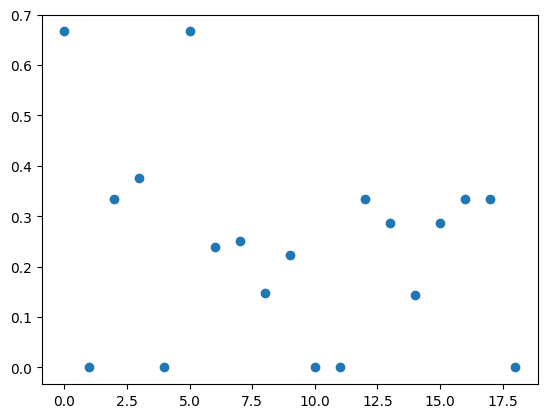

In [58]:
plt.scatter(list(range(19)), hcc3)

In [34]:
hcc1 = HCC1(complete_subgraphs_correct, a)

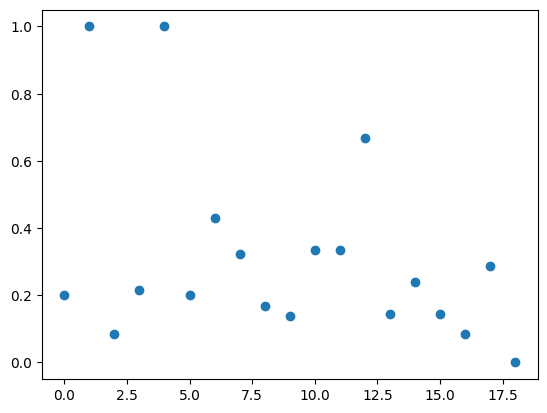

In [41]:
plt.scatter(list(range(19)), hcc1)

In [168]:
def CalculateKB(x, y):
    k = (y[1] - y[0]) / (x[1] - x[0])
    b = y[0] - k * x[0]
    return k, b

In [146]:
np.argsort(connect)

array([0, 1, 2])

In [141]:
a = np.sin(connect * 2*np.pi / 19).sort()

In [142]:
a

# Drafts

In [ ]:
all_possible_edges = []


In [ ]:
[245]  [24]

In [62]:
np.delete([[1, 2], [3, 4]], 1, axis=1)

array([[1],
       [3]])

In [21]:
def ReturnSubgraph(Graph, names, subnames):
    n = Graph.shape[0]
    new_Graph = np.zeros((n-1, n-1))
    i = 0 
    while i != len(subnames) and names[i] == subnames[i]:
        i += 1
    new_Graph = np.delete(Graph, i, axis=1)
    new_Graph = np.delete(new_Graph, i, axis=0)
    return new_Graph
            

def FindEdges(names):
    if len(names) == 1:
        return names
    edges = []
    for ind, v in enumerate(names):
        if ind + 1 == len(names):
            break
        subnames = names[ind+1:]#[names[i] for i in range(len(names)) if names[i] != v]
        #subgraph = ReturnSubgraph(Graph, names, subnames)
        subedges = FindEdges(subnames)
        if type(subedges[0]) != str:
            for i in range(len(subedges)):
                edges.append(subedges[i])
                edges.append([v] + subedges[i])
        else:
            edges.append(subedges)
            edges.append([v] + subedges)
    return edges

In [24]:
edges = FindEdges([str(i) for i in range(4)])

In [18]:
n = 19

c = 0
for k in range(n):
    print(math.comb(n, k))
    c += math.comb(n, k)

1
19
171
969
3876
11628
27132
50388
75582
92378
92378
75582
50388
27132
11628
3876
969
171
19


In [56]:
a = [i for i in range(19)]

In [61]:
cnk(k, 0)

In [45]:
p

array([2., 3.])

In [76]:
all_combs

[array([0.]),
 array([1.]),
 array([2.]),
 array([3.]),
 array([4.]),
 array([5.]),
 array([6.]),
 array([7.]),
 array([8.]),
 array([9.]),
 array([10.]),
 array([11.]),
 array([12.]),
 array([13.]),
 array([14.]),
 array([15.]),
 array([16.]),
 array([17.]),
 array([18.]),
 array([0., 1.]),
 array([0., 2.]),
 array([0., 3.]),
 array([0., 4.]),
 array([0., 5.]),
 array([0., 6.]),
 array([0., 7.]),
 array([0., 8.]),
 array([0., 9.]),
 array([ 0., 10.]),
 array([ 0., 11.]),
 array([ 0., 12.]),
 array([ 0., 13.]),
 array([ 0., 14.]),
 array([ 0., 15.]),
 array([ 0., 16.]),
 array([ 0., 17.]),
 array([ 0., 18.]),
 array([1., 2.]),
 array([1., 3.]),
 array([1., 4.]),
 array([1., 5.]),
 array([1., 6.]),
 array([1., 7.]),
 array([1., 8.]),
 array([1., 9.]),
 array([ 1., 10.]),
 array([ 1., 11.]),
 array([ 1., 12.]),
 array([ 1., 13.]),
 array([ 1., 14.]),
 array([ 1., 15.]),
 array([ 1., 16.]),
 array([ 1., 17.]),
 array([ 1., 18.]),
 array([2., 3.]),
 array([2., 4.]),
 array([2., 5.]),
 arra

In [19]:
c

524287

In [68]:
for i in range(len(edges)):
    edges[i].sort()

In [69]:
uniq_edges = []
for elem in edges:
    if elem not in uniq_edges:
        uniq_edges.append(elem)

In [70]:
len(uniq_edges)

31

In [78]:
a = np.array([[1, 2, 3], [2, 3, 4], [3, 4, 5]])
a[:, [1, 2]]

array([[2, 3],
       [3, 4],
       [4, 5]])